# Context:
The features were extracted from the silhouettes by the HIPS (Hierarchical Image Processing System) extension BINATTS, which 
extracts a combination of scale independent features utilising both classical moments based measures such as scaled variance, 
skewness and kurtosis about the major/minor axes and heuristic measures such as hollows, circularity, rectangularity and 
compactness. 

Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400.
This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be
readily distinguishable, but it would be more difficult to distinguish between the cars. 

Dataset link
https://archive.ics.uci.edu/ml/datasets/Statlog+(Vehicle+Silhouettes)

# Objective: 
To classify a given silhouette as one of three types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.

# Steps:
1. Data pre-processing - Understand the data and treat missing values (Use box plot), outliers (5 points)
2. Understanding the attributes - Find relationship between different attributes (Independent variables) and choose carefully which all attributes have to be a part of the analysis and why (5 points)
3. Use PCA from scikit learn and elbow plot to find out reduced number of dimension (which covers more than 95% of the variance) - 10 points
4. Use Support vector machines and use grid search (try C values - 0.01, 0.05, 0.5, 1 and kernel = linear, rbf) and find out the best hyper parameters and do cross validation to find the accuracy. (10 points)


In [1]:
# Import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.cross_validation import cross_val_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load data into pandas dataframe
df = pd.read_csv("vehicle.csv")

In [3]:
df.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


In [4]:
df.shape

(846, 19)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    841 non-null float64
distance_circularity           842 non-null float64
radius_ratio                   840 non-null float64
pr.axis_aspect_ratio           844 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  845 non-null float64
elongatedness                  845 non-null float64
pr.axis_rectangularity         843 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                843 non-null float64
scaled_variance.1              844 non-null float64
scaled_radius_of_gyration      844 non-null float64
scaled_radius_of_gyration.1    842 non-null float64
skewness_about                 840 non-null float64
skewness_about.1               845 non-null float64
skewness_about.2               845 non-null float64
hollows_ratio    

In [6]:
# checking the counts in Target field
df['class'].value_counts()

car    429
bus    218
van    199
Name: class, dtype: int64

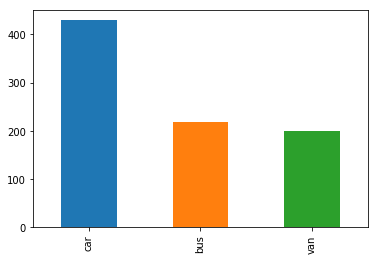

In [7]:
df['class'].value_counts().plot(kind='bar')

In [8]:
df.describe().T

# From Count we can see, few columns has some missing values.
# By comparing mean and median, we can say data in all fields are more or less normally distributed.
# Also, the features are not at the same scale. As mean varies between fields like skewness and length.
# To implement PCA, we have to bring the independent attribute values to the same scale.

,count,mean,std,min,25%,50%,75%,max
compactness,846.0,93.678487,8.234474,73.0,87.00,93.0,100.0,119.0
circularity,841.0,44.828775,6.152172,33.0,40.00,44.0,49.0,59.0
distance_circularity,842.0,82.110451,15.778292,40.0,70.00,80.0,98.0,112.0
radius_ratio,840.0,168.888095,33.520198,104.0,141.00,167.0,195.0,333.0
pr.axis_aspect_ratio,844.0,61.678910,7.891463,47.0,57.00,61.0,65.0,138.0
max.length_aspect_ratio,846.0,8.567376,4.601217,2.0,7.00,8.0,10.0,55.0
scatter_ratio,845.0,168.901775,33.214848,112.0,147.00,157.0,198.0,265.0
elongatedness,845.0,40.933728,7.816186,26.0,33.00,43.0,46.0,61.0
pr.axis_rectangularity,843.0,20.582444,2.592933,17.0,19.00,20.0,23.0,29.0
max.length_rectangularity,846.0,147.998818,14.515652,118.0,137.00,146.0,159.0,188.0


In [9]:
df.isnull().values.sum()

# 41 fields has Null values.

41

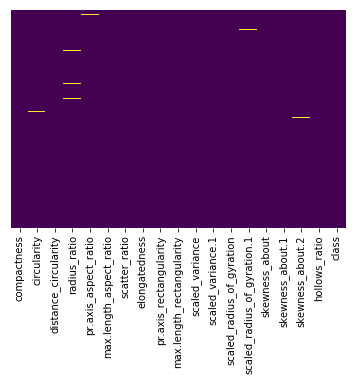

In [10]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# showing which independent attributes has null values

In [11]:
df.isnull().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

In [12]:
# replacing null with median of the columns.
# From 5 num summary (describe), we saw for all columns mean is almost equal to median.
# Hence data in those columns are normally distributed.
# So it is okay to use median values to replace null in any of these columns.

for i in df.columns[:17]:
    median_value = df[i].median()
    df[i] = df[i].fillna(median_value)

In [13]:
# checking for null after conversion
df.isnull().sum()

compactness                    0
circularity                    0
distance_circularity           0
radius_ratio                   0
pr.axis_aspect_ratio           0
max.length_aspect_ratio        0
scatter_ratio                  0
elongatedness                  0
pr.axis_rectangularity         0
max.length_rectangularity      0
scaled_variance                0
scaled_variance.1              0
scaled_radius_of_gyration      0
scaled_radius_of_gyration.1    0
skewness_about                 0
skewness_about.1               0
skewness_about.2               0
hollows_ratio                  0
class                          0
dtype: int64

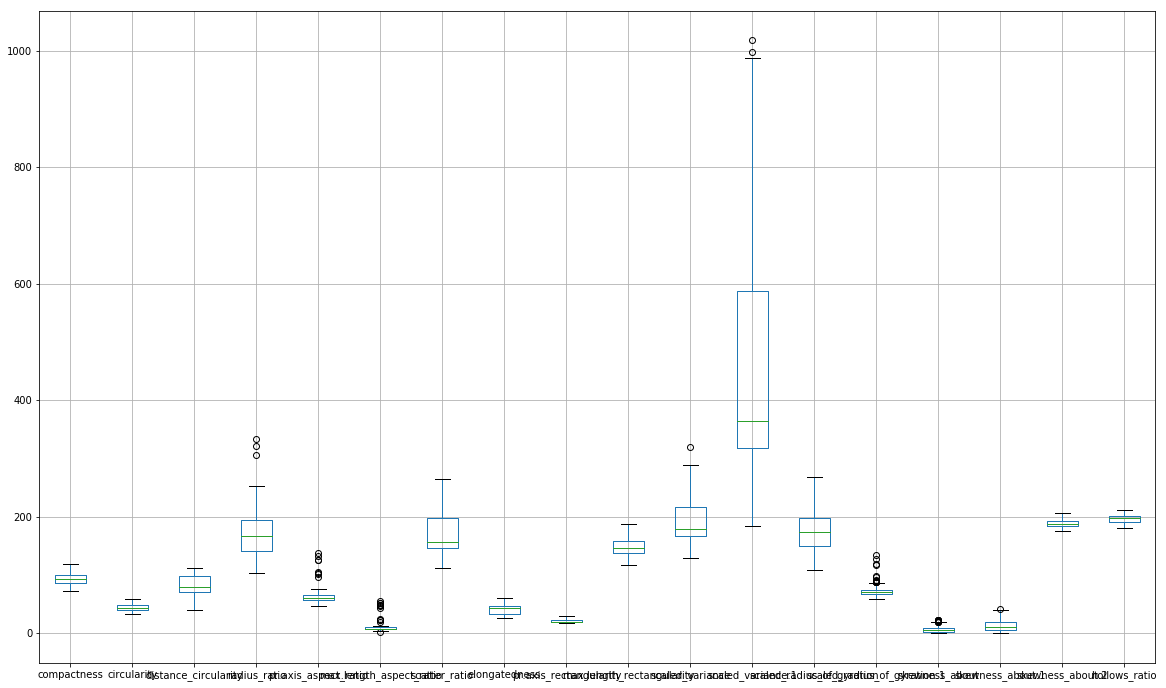

In [14]:
df.boxplot(figsize=(20,12))

# Result:
    # There are possible outliers in the following columns
        # radius_ratio
        # pr.axis_aspect_ratio
        # max.length_aspect_ratio
        # scaled_variance
        # scaled_variance.1
        # scaled_radius_of_gyration.1
        # skewness_about
        # skewness_about.1
    # We will see if these outliers can be replaced further.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C963C7D080>,
      dtype=object)

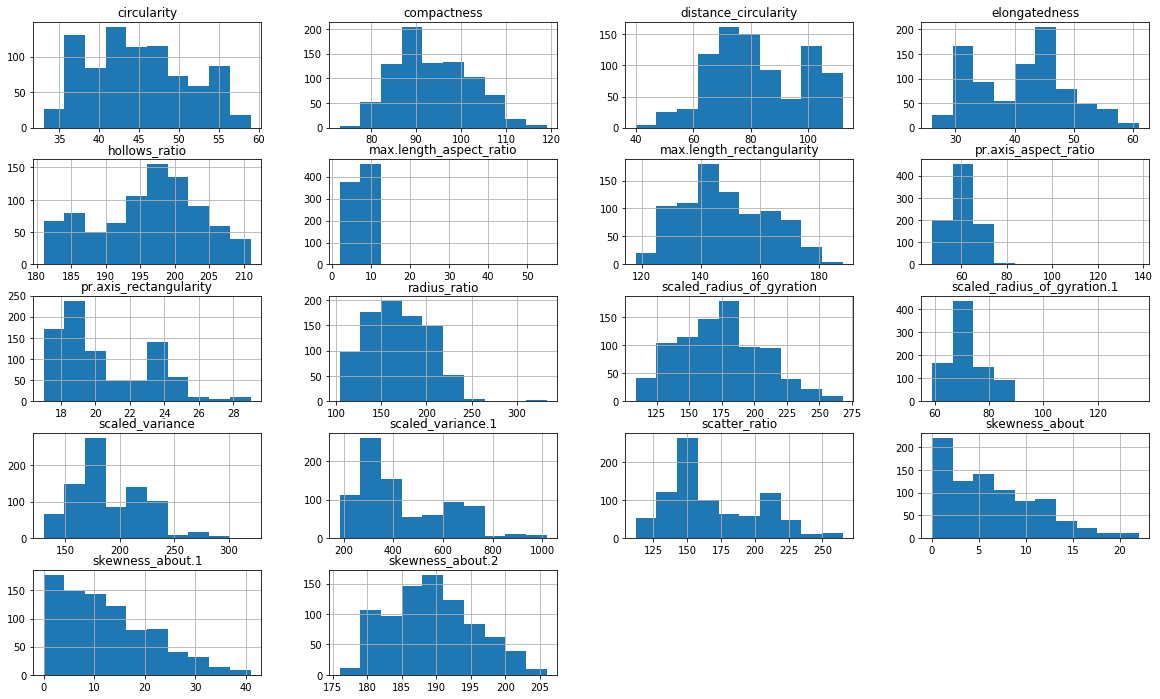

In [15]:
df.hist(figsize=(20,12))

# We saw from describe function and now in dist plot, that data in all fields are almost normally distributed.
# Few columns like max_length_aspect_ratio has outliers though. That we are going to address.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


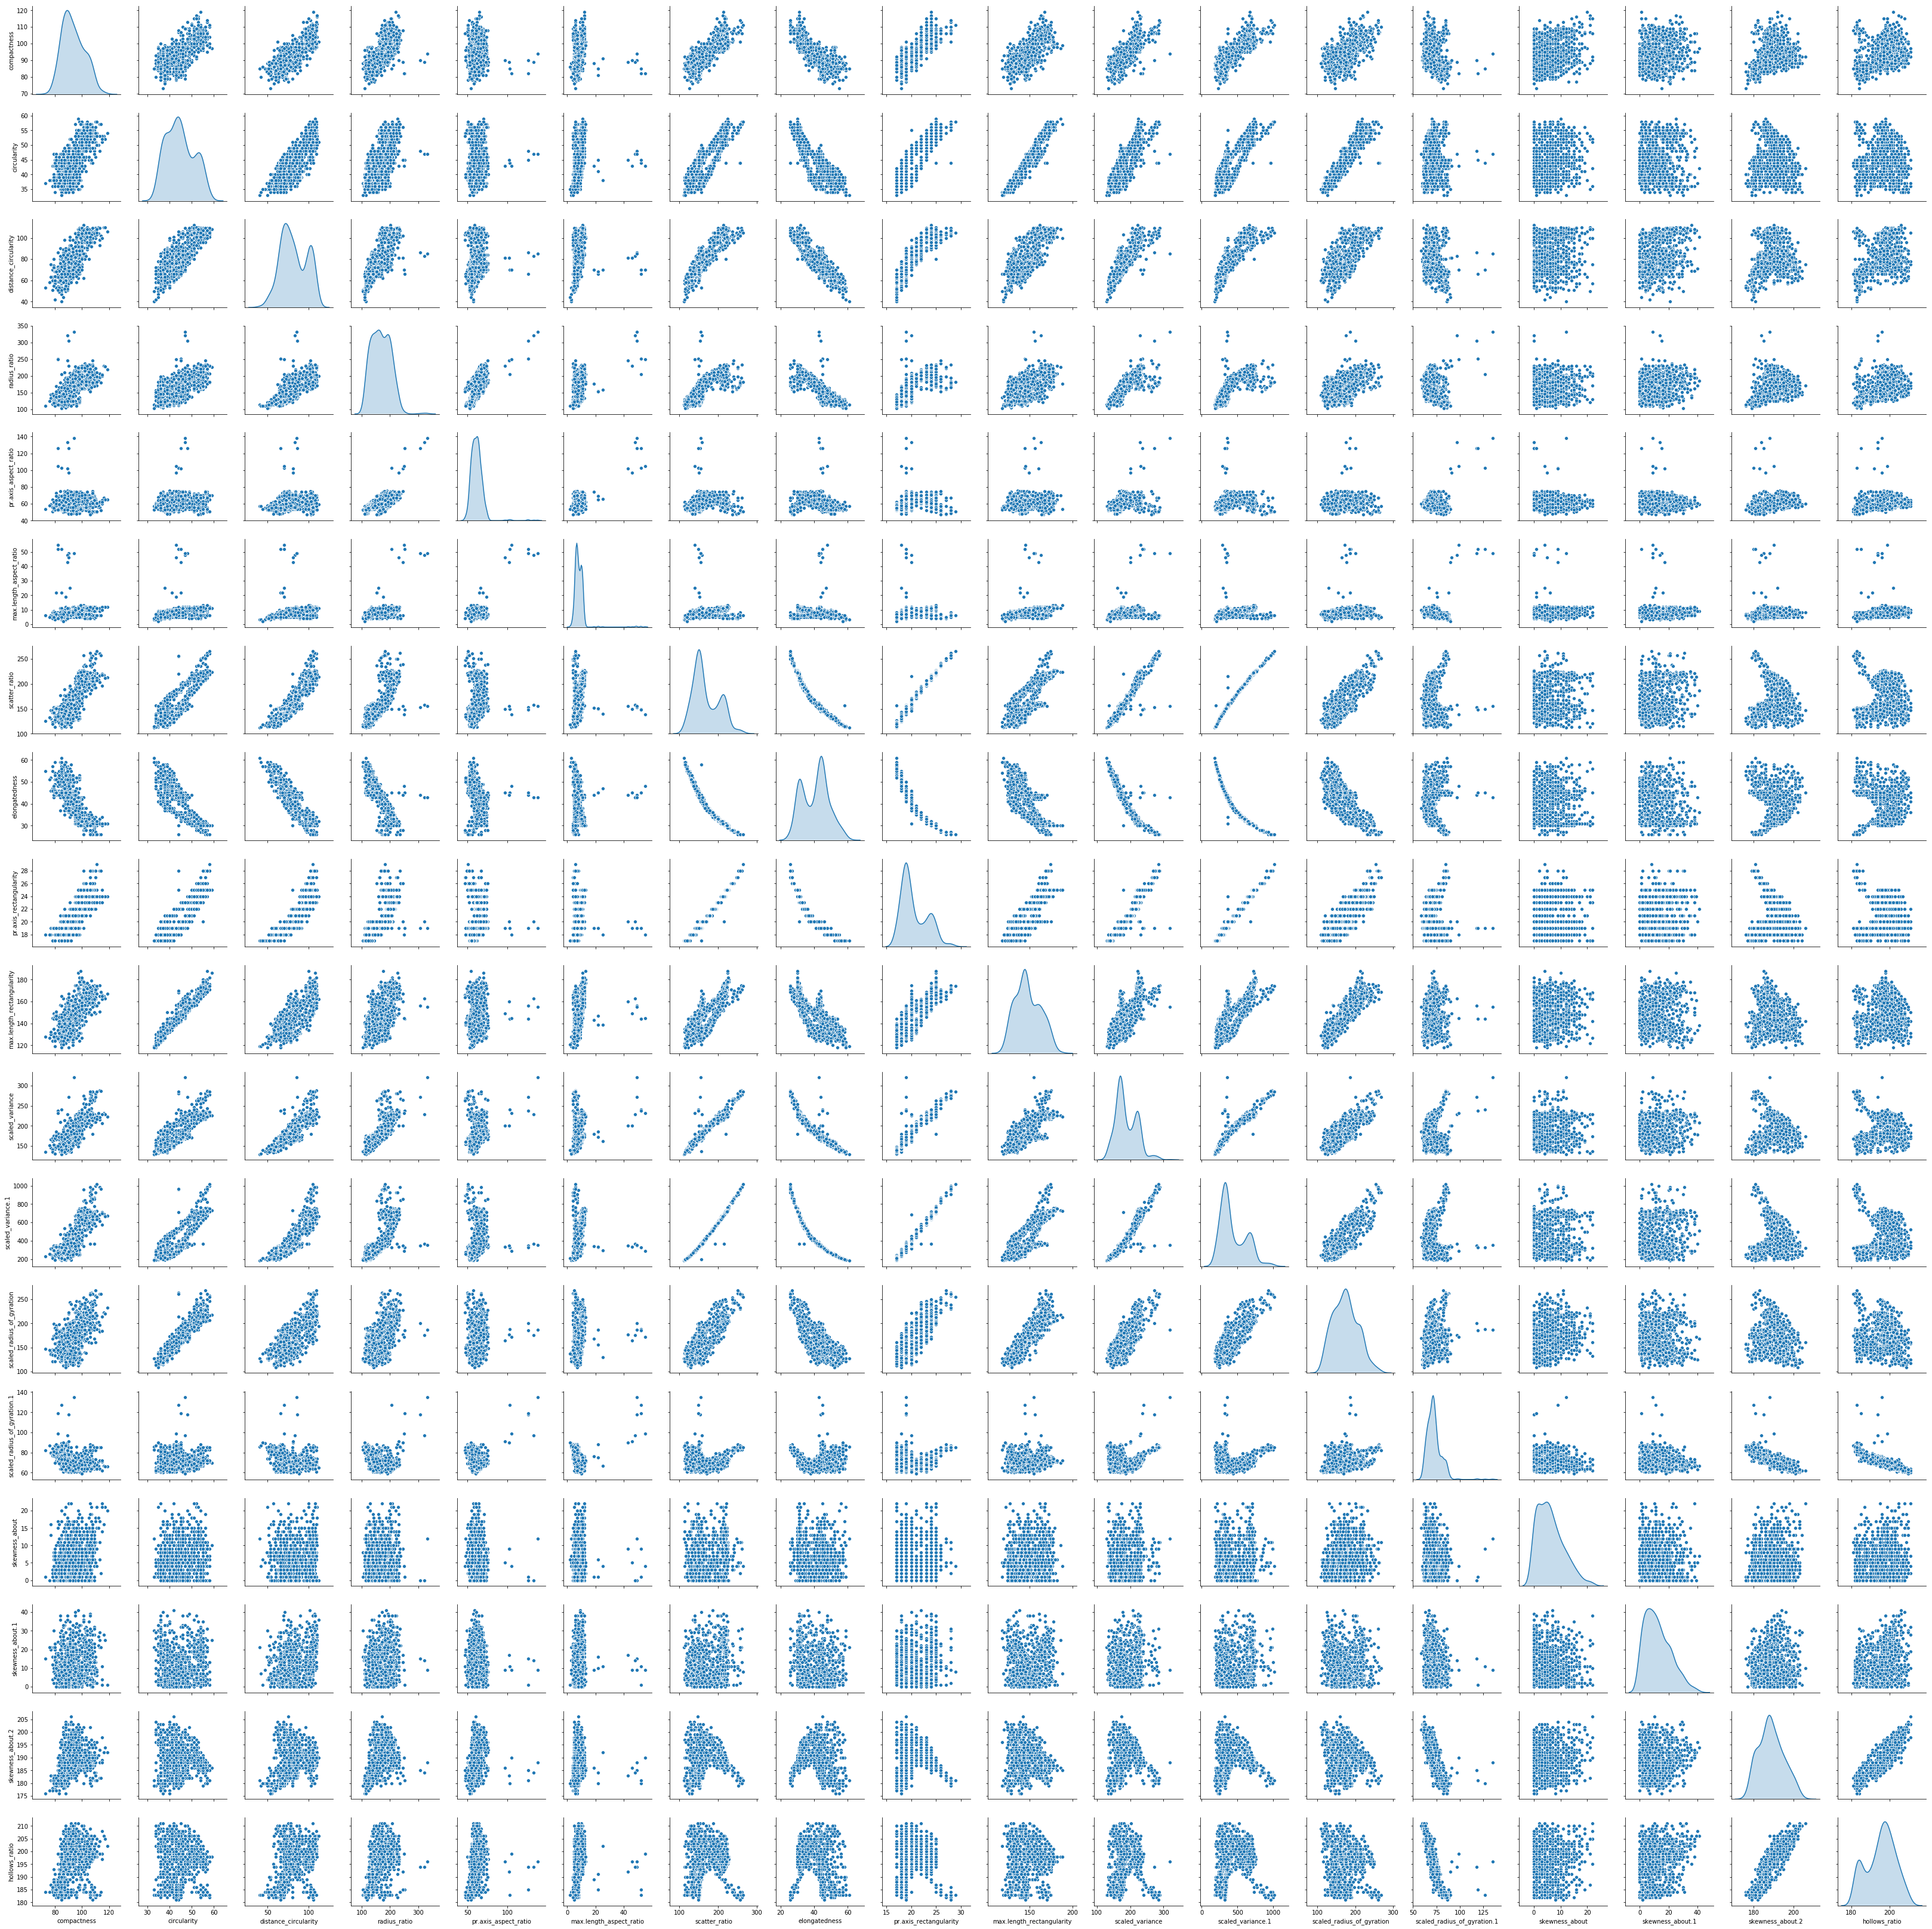

In [16]:
sns.pairplot(data=df, diag_kind='kde')

# pairplot shows, most of the independent attributes are linearly related to each other.
# very few are circularly related or not related.
# Therefore, this data set is well fit for the PCA implementation.
# However, we will analyse it further using correlation, heatmap and other EDA technique.

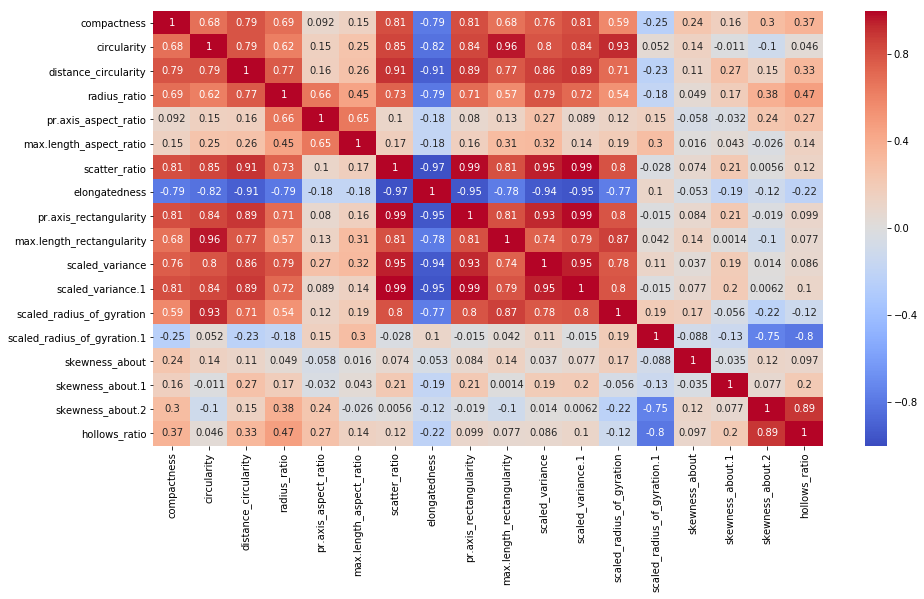

In [17]:
cor = df.corr()

plt.figure(figsize=(15,8))
sns.heatmap(data=cor, vmin=-1, vmax=1, cmap='coolwarm', annot=True)

# Result:
    # initial 12-13 attributes has very high correlation with each other.
    # Compactness has very high corr (>70%) with distance_circularity, radius_ratio, Scatter_ratio, pr.axis_rectangularity, scaled_variance, scaled_variance1
    # Circularity has very very high corr (>90%) with max length rectangularity and scaled_radius_of_gyration
    # Such high corelations are there for many attributes.
    # Pairplot showed the corelation between many fields are linear.
    # Therefore, it is wise to use PCA to reduce the dimensionality for this dataset.
    

### Removing Outliers

In [18]:
# creating copy of the dataframe.
# We will use the copied dataset and replace outliers.

df_c = df.copy(deep=True)

In [19]:
Q1 = df_c.quantile(0.25)
Q3 = df_c.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

compactness                     13.00
circularity                      9.00
distance_circularity            28.00
radius_ratio                    54.00
pr.axis_aspect_ratio             8.00
max.length_aspect_ratio          3.00
scatter_ratio                   51.00
elongatedness                   13.00
pr.axis_rectangularity           4.00
max.length_rectangularity       22.00
scaled_variance                 50.00
scaled_variance.1              268.50
scaled_radius_of_gyration       49.00
scaled_radius_of_gyration.1      8.00
skewness_about                   7.00
skewness_about.1                14.00
skewness_about.2                 9.00
hollows_ratio                   10.75
dtype: float64


In [20]:
for col_name in df_c.columns[:-1]:
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3 - q1
    
    low = q1-1.5*iqr
    high = q3+1.5*iqr
    
    df_c.loc[(df_c[col_name] < low) | (df_c[col_name] > high), col_name] = df_c[col_name].median()

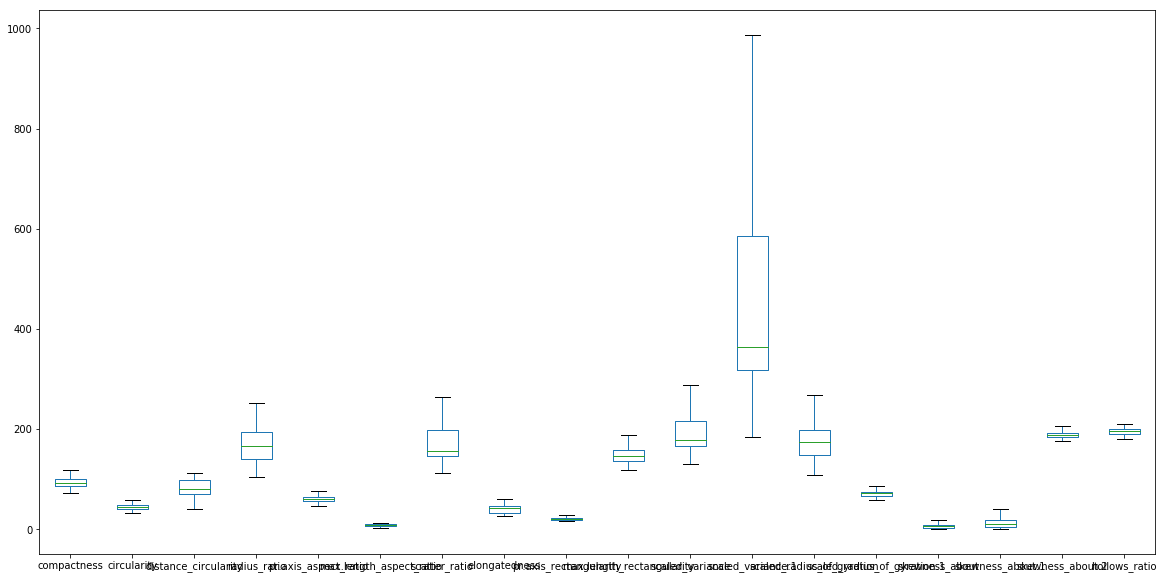

In [21]:
df_c.plot(kind='box', figsize=(20,10))

In [22]:
"""
## Z score implementation

from scipy import stats
import numpy as np

z = np.abs(stats.zscore(df))
print(z)

threshold = 3
print(np.where(z > 3))

"""

'\n## Z score implementation\n\nfrom scipy import stats\nimport numpy as np\n\nz = np.abs(stats.zscore(df))\nprint(z)\n\nthreshold = 3\nprint(np.where(z > 3))\n\n'

### Principal component analysis (PCA)
Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.

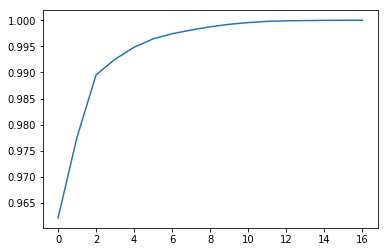

In [23]:
X = df_c.iloc[:,0:17]   # X is an array contains independent dimension only; standardizing data from mean to origin

# Now we will create PCA dimension
pca = PCA().fit(X)

# cumulative sum of dimension and line plot showing the varition explained by the algorithm.
plt.plot(np.cumsum(pca.explained_variance_ratio_))

# Result:
    # Out of 16 dimension, algorithm can able to explain maximum variation with 10 dimensions.
    # Using remaining dimensions are not adding much value.
    # Therefore, we can use 10 components to build the PCA model.

#### Another way to identify n_components using eigen_vectors and eigen_values.

In [24]:
# covariance matrix for identifying Principal components

# Step 1 - Create covariance matrix
cov_matrix = np.cov(X.T)
print('Covariance Matrix \n%s', cov_matrix)

Covariance Matrix 
%s [[ 6.78065662e+01  3.45953782e+01  1.02393288e+02  1.91108904e+02
   8.91493278e+00  8.49722047e+00  2.22142552e+02 -5.07377062e+01
   1.73442164e+01  8.08185544e+01  1.96740865e+02  1.15737644e+03
   1.56845875e+02 -1.25103809e+01  7.42980962e+00  1.14292109e+01
   1.51240421e+01]
 [ 3.45953782e+01  3.76292990e+01  7.65088408e+01  1.25871378e+02
   6.99890190e+00  7.09658260e+00  1.72677241e+02 -3.93651013e+01
   1.33922797e+01  8.55986081e+01  1.52824981e+02  8.84959558e+02
   1.84837067e+02  2.59720019e+00  3.82487026e+00 -5.26406200e-01
  -3.94100885e+00]
 [ 1.02393288e+02  7.65088408e+01  2.47796994e+02  4.01922920e+02
   2.15903409e+01  2.16662162e+01  4.72978160e+02 -1.12064585e+02
   3.63889560e+01  1.76978817e+02  4.24815891e+02  2.42596483e+03
   3.61587476e+02 -2.22357722e+01  7.13424958e+00  3.66615077e+01
   1.41490327e+01]
 [ 1.91108904e+02  1.25871378e+02  4.01922920e+02  1.03348796e+03
   1.17399578e+02  3.07868675e+01  8.21709399e+02 -2.07285358e+

In [25]:
# Step 2 - Get eigen values and eigen vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eig_vecs)
print('\n Eigen Values \n%s', eig_vals)

Eigen Vectors 
%s [[-3.61181699e-02  6.22334513e-02 -2.08449006e-02 -5.20843980e-02
   1.79567686e-01  2.35328875e-01 -2.73657741e-01 -4.17899938e-01
  -2.61962924e-01 -2.95553143e-02  7.36723137e-01  1.36994861e-01
   9.15911809e-02 -1.02214962e-02 -1.02561237e-01 -5.34479551e-02
  -4.03293049e-02]
 [-2.78585163e-02 -6.95484469e-02 -1.10890659e-01 -6.05101649e-02
   1.03661208e-01  5.06220604e-02  1.24043168e-01 -9.56025523e-02
   4.11384945e-02 -4.56305289e-03 -4.52335537e-02 -1.32224420e-02
   1.11874929e-02  2.46685747e-02  6.70538686e-02  4.11575566e-01
  -8.72946409e-01]
 [-7.60037326e-02  9.31410979e-02 -1.13276406e-01  8.62930794e-02
   5.60379641e-01  1.61751464e-01 -7.96346749e-02  6.69976425e-01
   9.23033455e-02 -2.25619322e-01  1.68080580e-01  2.10857202e-01
  -1.44671986e-01 -3.37952415e-03  1.19387612e-01 -4.37032241e-02
  -2.51108307e-02]
 [-1.34560564e-01  7.16812657e-01 -5.54387439e-01 -1.12203320e-01
  -1.44187338e-01 -1.41151471e-01  1.25514190e-01 -1.72416374e-02
 

Cumulative Variance Explained [ 96.21465997  97.76354343  98.95487594  99.2547677   99.48214724
  99.64405332  99.74196245  99.81285463  99.8744904   99.92251796
  99.95540241  99.97834357  99.98870693  99.99368845  99.99734066
  99.99968696 100.        ]


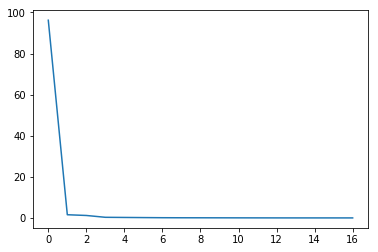

In [26]:
# Step 3 - % of Cumulative variance explained 

tot = sum(eig_vals)
var_exp = [( i /tot ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)

plt.plot(var_exp)

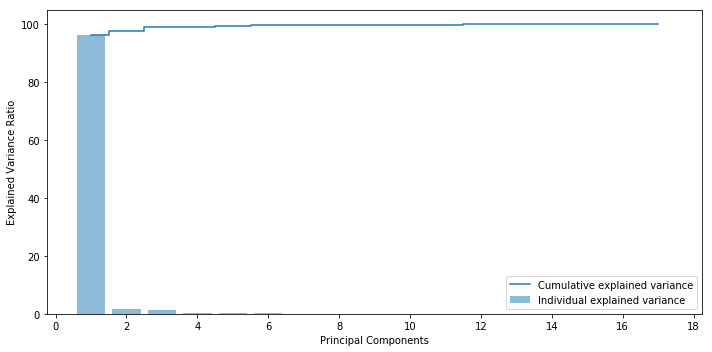

In [27]:
# Step 4 - Cumulative explained vs Individual explained variance

plt.figure(figsize=(10 , 5))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.xticks(np.arange(0, 19, step=2))
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()


# Here too it shows, 10-12 principle components has been enough to explain maximum model variaiton.
# So we will be using 10 PCA dimensions.

In [28]:
# Using 10 PC and transforming the array contains independent attributes
pca = PCA(n_components=10)
pca.fit(X)

X = pca.transform(X)

#### Spliting data for Classification model

In [29]:
from sklearn import cross_validation
Y = df.iloc[:,18]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=9)

### Using Classification algorithm

#### Support Vector Classification

In [35]:
# Support Vector Machine on trainig data

# Grid search has not yet covered in the course. 
# Therefore, using different parameters individually and checking the cross validation score.

# C values - 0.01, 0.05, 0.5, 1 and kernel = linear, with 5 cross-validation generator

model1_l = SVC(C=1, kernel='linear')
score1_l = cross_val_score(model1_l, X_train, y_train, cv=5)
print('Cross validation score with C=1 and kernel=linear:',score1_l)

model0_5_l = SVC(C=0.5, kernel='linear')
score0_5_l = cross_val_score(model0_5_l, X_train, y_train, cv=5)
print('Cross validation score with C=0.5 and kernel=linear:',score0_5_l)

model0_05_l = SVC(C=0.05, kernel='linear')
score0_05_l = cross_val_score(model0_05_l, X_train, y_train, cv=5)
print('Cross validation score with C=0.05 and kernel=linear:',score0_05_l)

model0_01_l = SVC(C=0.01, kernel='linear')
score0_01_l = cross_val_score(model0_01_l, X_train, y_train, cv=5)
print('Cross validation score with C=0.01 and kernel=linear:',score0_01_l)

print('')
print("Accuracy with C=1 and kernel=linear: %0.2f (+/- %0.2f)" % (score1_l.mean(), score1_l.std() * 2))
print("Accuracy with C=0.5 and kernel=linear: %0.2f (+/- %0.2f)" % (score0_5_l.mean(), score0_5_l.std() * 2))
print("Accuracy with C=0.05 and kernel=linear: %0.2f (+/- %0.2f)" % (score0_05_l.mean(), score0_05_l.std() * 2))
print("Accuracy with C=0.01 and kernel=linear: %0.2f (+/- %0.2f)" % (score0_01_l.mean(), score0_01_l.std() * 2))

# Result shows the cross validation score for different parameters and accuracy by calculating the mean of cross validation.

Cross validation score with C=1 and kernel=linear: [0.79831933 0.81512605 0.78813559 0.87288136 0.84745763]
Cross validation score with C=0.5 and kernel=linear: [0.79831933 0.81512605 0.78813559 0.87288136 0.84745763]
Cross validation score with C=0.05 and kernel=linear: [0.79831933 0.82352941 0.80508475 0.86440678 0.8559322 ]
Cross validation score with C=0.01 and kernel=linear: [0.79831933 0.81512605 0.81355932 0.87288136 0.86440678]

Accuracy with C=1 and kernel=linear: 0.82 (+/- 0.06)
Accuracy with C=0.5 and kernel=linear: 0.82 (+/- 0.06)
Accuracy with C=0.05 and kernel=linear: 0.83 (+/- 0.05)
Accuracy with C=0.01 and kernel=linear: 0.83 (+/- 0.06)


In [31]:
# C values - 0.01, 0.05, 0.5, 1 and kernel = rbf

model1_r = SVC(C=1, kernel='rbf')
score1_r = cross_val_score(model1_r, X_train, y_train, cv=5)
print('Cross validation score with C=1 and kernel=rbf:',score1_r)

model0_5_r = SVC(C=0.5, kernel='rbf')
score0_5_r = cross_val_score(model0_5_r, X_train, y_train, cv=5)
print('Cross validation score with C=0.5 and kernel=rbf:',score0_5_r)

model0_05_r = SVC(C=0.05, kernel='rbf')
score0_05_r = cross_val_score(model0_05_r, X_train, y_train, cv=5)
print('Cross validation score with C=0.05 and kernel=rbf:',score0_05_r)

model0_01_r = SVC(C=0.01, kernel='rbf')
score0_01_r = cross_val_score(model0_01_r, X_train, y_train, cv=5)
print('Cross validation score with C=0.01 and kernel=rbf:',score0_01_r)


print('')
print("Accuracy with C=1 and kernel=rbf: %0.2f (+/- %0.2f)" % (score1_r.mean(), score1_r.std() * 2))
print("Accuracy with C=0.5 and kernel=rbf: %0.2f (+/- %0.2f)" % (score0_5_r.mean(), score0_5_r.std() * 2))
print("Accuracy with C=0.05 and kernel=rbf: %0.2f (+/- %0.2f)" % (score0_05_r.mean(), score0_05_r.std() * 2))
print("Accuracy with C=0.01 and kernel=rbf: %0.2f (+/- %0.2f)" % (score0_01_r.mean(), score0_01_r.std() * 2))

# scores look similar with all C values, but model did well with kernel=linear than kernel=rbf

Cross validation score with C=1 and kernel=rbf: [0.49579832 0.49579832 0.49152542 0.49152542 0.49152542]
Cross validation score with C=0.5 and kernel=rbf: [0.49579832 0.49579832 0.49152542 0.49152542 0.49152542]
Cross validation score with C=0.05 and kernel=rbf: [0.49579832 0.49579832 0.49152542 0.49152542 0.49152542]
Cross validation score with C=0.01 and kernel=rbf: [0.49579832 0.49579832 0.49152542 0.49152542 0.49152542]

Accuracy with C=1 and kernel=rbf: 0.49 (+/- 0.00)
Accuracy with C=0.5 and kernel=rbf: 0.49 (+/- 0.00)
Accuracy with C=0.05 and kernel=rbf: 0.49 (+/- 0.00)
Accuracy with C=0.01 and kernel=rbf: 0.49 (+/- 0.00)


In [32]:
# checking the model score with Test data for parameter C=1 and kernel=linear
svc_model = SVC(C=1, kernel='linear').fit(X_train, y_train)
svc_model.score(X_test, y_test)

0.8464566929133859

#### Gaussian Naive Bayes

In [33]:
# Trying Gaussian Naive Bayes

model = GaussianNB()
scores = cross_val_score(model, X_train, y_train, cv=5)
print('Cross validation score:',scores)

# Model score
nb_model = GaussianNB().fit(X_train, y_train)
nb_model.score(X_test, y_test)

Cross validation score: [0.76470588 0.72268908 0.78813559 0.77966102 0.77118644]


0.7952755905511811

## Conclusion

- After analyzing data, we found dataset had some Null records and quite a few Outliers in the Independent columns.
- Using various technique and findings, we have replaced the Null records and outliers with meadian value of those columns.
- From Pairplot and correlation heatmap, we could see many attributes are linearly correlated to each other.
- Therefore, any model we use would face the curse of dimensionality challenges.
- Hence, we used PCA technique to find out the right number of Principal components, which explain maximum variance and so we can reduce the dimensionality.
- We found the n_components number to be 10, and the same has been used for Support Vector Classification model.
- The SVC model has been cross validated with various penalty parameters (C - 1, 0.5, 0.05, 0.01) and kernel values (linear, rbf)
- From cross validation, we found the best accuracy from SVC model with C=1 and kernel=linear.
- We used this values to train the model with train data and checked the score using test data, which came out to around 85%.
- We have also used Gaussian Naive Bayes classification algorithm to see if the score improves.
- But the SVC model proved to be the better model for this dataset than GaussianNB.